In [110]:
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

os.listdir()

['.ipynb_checkpoints',
 'Backpropogation.ipynb',
 'ex4data1.mat',
 'ex4weights.mat']

# Loading data

In [111]:
data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')

In [112]:
type(data)

dict

In [113]:
print("data keys: ",data.keys())
print("Weight keys: ",weights.keys())

data keys:  dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Weight keys:  dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])


# Initializing data

In [114]:
X = data['X']
y = data['y']
theta1 = weights['Theta1']
theta2 = weights['Theta2']

In [115]:
print(X.shape)
print(y.shape) 
print(theta1.shape)
print(theta2.shape)


(5000, 400)
(5000, 1)
(25, 401)
(10, 26)


In [116]:
print(np.unique(y))

[ 1  2  3  4  5  6  7  8  9 10]


# Vizualizing data

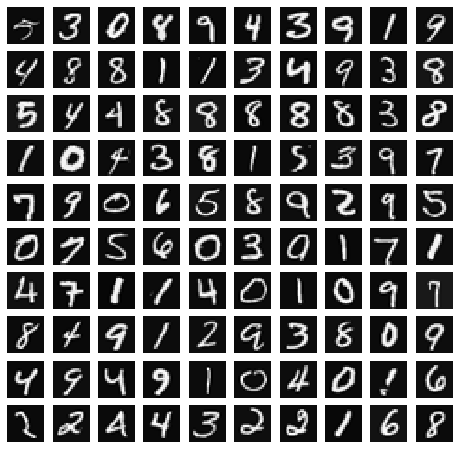

In [117]:
fig,axes = plt.subplots(10,10,figsize=(8,8))

for i in range(10):
    for j in range(10):
        axes[i][j].imshow(X[np.random.randint(0,5001),:].reshape((20,20),order='F'),cmap='gist_gray')
        axes[i][j].axis('off')

# Feedforward and cost function

In [118]:
X = np.c_[np.ones((5000,1)),X]
m , n = X.shape

# 1

In [119]:
def hypothesis(z):
    hx = 1/(1+np.exp(-z))
    return(hx)

In [120]:
def sigmgradient(z):
    dg = hypothesis(z)*(1-hypothesis(z))
    return dg
print(sigmgradient(0))

0.25


In [121]:
def randominit(m,n):
    theta = np.random.uniform(low=-0.12,high=0.12,size=(m,n))
    return theta
    

In [122]:
def nncostfunction(theta,X,y,lambd):
    inputlayer = 400
    hiddenlayer = 25
    label = 10
    m,n = X.shape
    yy = np.zeros((m,10))
    cost = [0]*m
    theta1 = theta[:(hiddenlayer*(inputlayer+1))].reshape((hiddenlayer,inputlayer+1))    
    theta2 = theta[(hiddenlayer*(inputlayer+1)):].reshape((label,hiddenlayer+1))
    D1 = np.zeros_like(theta1)
    D2 = np.zeros_like(theta2)
    
    for i in range(m):
        yy[i][y[i]-1] = 1
    for i in range(m):
        a1 = X[i,:].reshape((n,1))
        z2 = theta1.dot(a1)  #(25x401)(401x1)=(25x1)
        a2 = hypothesis(z2)
        a2 = np.vstack((np.ones(1),a2))  #(26x1)
        z3 = theta2.dot(a2)   #(10x26)(26x1)=(10x1)
        a3 = hypothesis(z3)#10x1
        cost[i] = (np.sum(-yy[i]*(np.log(a3.T)) - (1-yy[i])*(np.log(1-a3.T))))/m
    
        d3 = a3 - yy[i][:,None]  #(10x1)-(10x1)
        d2 = np.dot(theta2.T,d3)[1:]*sigmgradient(z2)  #(26x10)x(10x1)=(26x1)[1:]*25x1
    
        D1 = D1 + np.dot(d2,a1.T) #(25x1)x(1x401) = (25x401)
        D2 = D2 + np.dot(d3,a2.T) #(10x1)x(1x26) = (10x26)

    grad1 = 1/m*D1
    grad2 = 1/m*D2
    grad_final = np.array(np.append(grad1.ravel(),grad2.ravel()))



    reg = (lambd/(2*m))*((np.sum(np.square(theta1[:,1:401]))) + (np.sum(np.square(theta2[:,1:26]))))


    cost = sum(cost)+reg
    
    return(cost,grad_final)


In [123]:
#Checking cost at lamda=0 and provided theta1 and theta2

theta = np.append(theta1,theta2).reshape(-1)
cost = nncostfunction(theta,X,y,0)
cost[0]

0.28762916516131876

# Main() 

In [124]:
inputlayer = 400
hiddenlayer = 25
label = 10
lambd = 3

In [125]:
#Random initializing of theta between epsilon(-0.12,0.12)

theta_1 = randominit(hiddenlayer,inputlayer+1) #(25x401)
theta_2 = randominit(label,hiddenlayer+1)   #(10x26)

In [126]:
#append theta1 and theta2 to pass to the optimization in 1-D

theta_initial = np.append(theta_1,theta_2).reshape(-1)


# optimization using fmin_tnc

In [127]:
thetaf , nf ,rc  = opt.fmin_tnc(func=nncostfunction, x0=theta_initial ,args=(X,y,lambd))

#unrolling thetas back to orignal shapes

theta1 = thetaf[:(hiddenlayer*(inputlayer+1))].reshape((hiddenlayer,inputlayer+1))    
theta2 = thetaf[(hiddenlayer*(inputlayer+1)):].reshape((label,hiddenlayer+1))
print(theta1.shape)
print(theta2.shape)


(25, 401)
(10, 26)


# Feedforward with calculated theta values

In [131]:
y = np.where(y==10,0,y)
predict = []

#feedforward
for i in range(m):
    a1 = X[i,:].reshape((n,1))
    z2 = theta1.dot(a1 )  #(25x401)(401x1)=(25x1)
    a2 = hypothesis(z2)
    a2 = np.vstack((np.ones(1),a2))  #(26x1)
    z3 = theta2.dot(a2)   #(10x26)(26x1)=(10x1)
    a3 = hypothesis(z3)
    pp[i] = a3.T
    a3list = list(a3)
    predict.append((a3list.index(max(a3))+1)%10)  #append the largest probability index
print(len(predict))

5000


# Prediction and accuracy

In [133]:
predict = np.array(predict).reshape((m,1))
accuracy = np.mean(predict==y)*100
accuracy

95.84

Label:  [6]


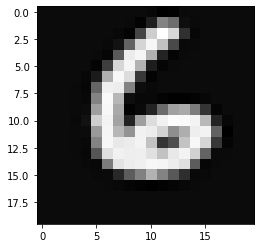

In [134]:
print("Label: ",predict[3465])
plt.imshow(X[3465,1:].reshape(20,20,order='F'),cmap = 'gist_gray')